In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


NVIDIA A30
(872, 4500, 14) (872,)


# Anomaly Aware GAN

In [4]:
# Data preprocessing with normalization
def preprocess_data(data, scaler=None, fit_scaler=True):
    """
    Preprocess data with normalization
    Returns normalized data and scaler for denormalization
    """
    original_shape = data.shape
    data_reshaped = data.reshape(-1, data.shape[-1])
    
    if scaler is None:
        scaler = StandardScaler()
    
    if fit_scaler:
        normalized_data = scaler.fit_transform(data_reshaped)
    else:
        normalized_data = scaler.transform(data_reshaped)
    
    return normalized_data.reshape(original_shape), scaler

def denormalize_data(data, scaler):
    """
    Denormalize data back to original scale
    """
    original_shape = data.shape
    data_reshaped = data.reshape(-1, data.shape[-1])
    denormalized_data = scaler.inverse_transform(data_reshaped)
    return denormalized_data.reshape(original_shape)

# Encoder for BiGAN (adapted for multivariate time series)
class Encoder(nn.Module):
    def __init__(self, channels=14, seq_len=4500, latent_dim=100):
        super(Encoder, self).__init__()
        
        # Calculate feature map sizes after convolutions
        # After conv1: seq_len/2, After conv2: seq_len/4, After conv3: seq_len/8, After conv4: seq_len/16
        final_seq_len = seq_len // 16  # ~281
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second conv block  
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third conv block
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Fourth conv block
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate the flattened size
        self.flattened_size = 512 * final_seq_len
        
        # Final layers to latent space
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, latent_dim)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Generator for BiGAN (adapted for multivariate time series)
class BiGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(BiGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.seq_len = seq_len
        
        # Start with a smaller sequence length and upsample
        self.init_seq_len = seq_len // 16  # ~281
        
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512 * self.init_seq_len),
            nn.BatchNorm1d(512 * self.init_seq_len),
            nn.ReLU(inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            # First deconv block
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            # Second deconv block
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # Third deconv block
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # Final deconv block
            nn.ConvTranspose1d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc_layer(z)
        out = out.view(out.shape[0], 512, self.init_seq_len)
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length through interpolation if needed
        if out.size(2) != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        return out

# Joint Discriminator for BiGAN (takes both data and latent code)
class BiGANDiscriminator(nn.Module):
    def __init__(self, channels=14, seq_len=4500, latent_dim=100):
        super(BiGANDiscriminator, self).__init__()
        
        # Data pathway - similar to your original discriminator
        final_seq_len = seq_len // 16  # After 4 conv layers with stride 2
        
        self.data_path = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten()
        )
        
        self.data_feature_size = 512 * final_seq_len
        
        # Latent pathway
        self.latent_path = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Joint discriminator
        self.joint_discriminator = nn.Sequential(
            nn.Linear(self.data_feature_size + 512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, z):
        data_features = self.data_path(x)
        latent_features = self.latent_path(z)
        joint_features = torch.cat([data_features, latent_features], dim=1)
        return self.joint_discriminator(joint_features)

# BiGAN Model wrapper
class BiGAN(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(BiGAN, self).__init__()
        self.generator = BiGANGenerator(latent_dim, channels, seq_len)
        self.encoder = Encoder(channels, seq_len, latent_dim)
        self.discriminator = BiGANDiscriminator(channels, seq_len, latent_dim)
        self.latent_dim = latent_dim
        
    def forward(self, x=None, z=None, mode='encode'):
        if mode == 'encode':
            return self.encoder(x)
        elif mode == 'generate':
            return self.generator(z)
        elif mode == 'discriminate':
            return self.discriminator(x, z)

# Anomaly detection using reconstruction and encoding errors
def compute_anomaly_scores(bigan, data_loader, device, data_scaler=None):
    """
    Compute anomaly scores using both reconstruction and encoding errors
    """
    bigan.eval()
    anomaly_scores = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            
            # Encode real data
            encoded_z = bigan.encoder(batch_data)
            
            # Reconstruct from encoded latent
            reconstructed_x = bigan.generator(encoded_z)
            
            # Reconstruction error
            recon_error = torch.mean((batch_data - reconstructed_x) ** 2, dim=(1, 2))
            
            # Encoding consistency error
            random_z = torch.randn_like(encoded_z)
            generated_x = bigan.generator(random_z)
            encoded_generated = bigan.encoder(generated_x)
            encoding_error = torch.mean((random_z - encoded_generated) ** 2, dim=1)
            
            # Combined anomaly score (weighted combination)
            combined_score = 0.7 * recon_error + 0.3 * encoding_error
            anomaly_scores.extend(combined_score.cpu().numpy())
    
    return np.array(anomaly_scores)

class FewShot1DDataset(Dataset):
    def __init__(self, data):
        # Convert from (samples, seq_len, channels) to (samples, channels, seq_len) for Conv1d
        self.data = torch.tensor(data.transpose(0, 2, 1), dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], 0  # Return dummy label

# Anomaly Aware GAN Training

In [ ]:
# Clear GPU memory first
torch.cuda.empty_cache()

# Preprocessing with normalization
normal_data_normalized, data_scaler = preprocess_data(normal_data, fit_scaler=True)

# Training parameters - reduced for memory efficiency
latent_dim = 64  # Reduced from 100
epochs = 50      # Reduced epochs for initial testing
batch_size = 16  # Reduced batch size
save_interval = 10

# Data loading
dataset = FewShot1DDataset(normal_data_normalized)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # Reduced workers

# Initialize BiGAN with smaller parameters
bigan = BiGAN(latent_dim=latent_dim, channels=14, seq_len=4500).to(device)

# Check model size
total_params = sum(p.numel() for p in bigan.parameters())
print(f"Total parameters: {total_params:,}")

# Optimizers with gradient clipping for stability
optimizer_G = optim.Adam(bigan.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Reduced LR
optimizer_E = optim.Adam(bigan.encoder.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(bigan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop with memory management
g_losses, e_losses, d_losses = [], [], []

print("Starting BiGAN Training...")
for epoch in range(epochs):
    epoch_g_loss, epoch_e_loss, epoch_d_loss = 0, 0, 0
    
    for i, (real_samples, _) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size_current = real_samples.size(0)
        
        # Labels for real and fake (with label smoothing)
        real_labels = torch.ones(batch_size_current, 1, device=device) * 0.9
        fake_labels = torch.zeros(batch_size_current, 1, device=device) + 0.1
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Real data with encoded latent: D(x, E(x)) -> should be 1
        encoded_z = bigan.encoder(real_samples)
        real_validity = bigan.discriminator(real_samples, encoded_z)
        d_real_loss = adversarial_loss(real_validity, real_labels)
        
        # Fake data with random latent: D(G(z), z) -> should be 0
        z = torch.randn(batch_size_current, latent_dim, device=device)
        fake_samples = bigan.generator(z)
        fake_validity = bigan.discriminator(fake_samples.detach(), z)
        d_fake_loss = adversarial_loss(fake_validity, fake_labels)
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(bigan.discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()
        
        # ---------------------
        #  Train Generator and Encoder
        # ---------------------
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()
        
        # Generator loss: D(G(z), z) -> should be 1 (fool discriminator)
        fake_samples = bigan.generator(z)
        g_validity = bigan.discriminator(fake_samples, z)
        g_loss = adversarial_loss(g_validity, real_labels)
        
        # Encoder loss: D(x, E(x)) -> should be 0 (fool discriminator)
        encoded_z = bigan.encoder(real_samples)
        e_validity = bigan.discriminator(real_samples, encoded_z)
        e_loss = adversarial_loss(e_validity, fake_labels)
        
        # Combined Generator-Encoder loss
        ge_loss = g_loss + e_loss
        ge_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(bigan.generator.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(bigan.encoder.parameters(), max_norm=1.0)
        
        optimizer_G.step()
        optimizer_E.step()
        
        # Statistics
        epoch_g_loss += g_loss.item()
        epoch_e_loss += e_loss.item()
        epoch_d_loss += d_loss.item()
        
        # Clear cache periodically
        if i % 10 == 0:
            torch.cuda.empty_cache()
        
        
        print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                f"[E loss: {e_loss.item():.4f}]")

    # Store losses
    g_losses.append(epoch_g_loss / len(dataloader))
    e_losses.append(epoch_e_loss / len(dataloader))
    d_losses.append(epoch_d_loss / len(dataloader))
    
    # Monitor training stability every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} - Avg Losses: D={d_losses[-1]:.4f}, G={g_losses[-1]:.4f}, E={e_losses[-1]:.4f}")
        
        # Check GPU memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(device) / 1024**3  # GB
            memory_reserved = torch.cuda.memory_reserved(device) / 1024**3    # GB
            print(f"GPU Memory - Allocated: {memory_allocated:.2f}GB, Reserved: {memory_reserved:.2f}GB")
        
        # Clear cache
        torch.cuda.empty_cache()

print("BiGAN Training completed!")

# Generate samples function with memory management
def generate_bigan_samples(bigan, num_samples, data_scaler, latent_dim=64):
    """
    Generate samples using trained BiGAN and denormalize them
    """
    device = next(bigan.parameters()).device
    bigan.eval()
    
    batch_size = 8  # Small batch size for memory efficiency
    all_samples = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            batch_samples = bigan.generator(z)  # Shape: (batch, 14, 4500)
            all_samples.append(batch_samples.cpu())
            
            # Clear cache after each batch
            torch.cuda.empty_cache()
    
    generated_data = torch.cat(all_samples, dim=0).numpy()
    generated_data = generated_data.transpose(0, 2, 1)  # Convert to (n_samples, 4500, 14)
    
    # Denormalize to original scale
    generated_data_denorm = denormalize_data(generated_data, data_scaler)
    
    return generated_data_denorm

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Generate and Combine

In [4]:
# Generate samples
num_samples = len(normal_data)  # Number of samples to generate
generated_data = generate_samples(generator, num_samples)

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)


# Processing: Mel Spec > Resizing > Feature Extraction

In [5]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [6]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [7]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 1.132798
Epoch 2/15, Loss: 0.788073
Epoch 3/15, Loss: 0.562813
Epoch 4/15, Loss: 0.532093
Epoch 5/15, Loss: 0.527973
Epoch 6/15, Loss: 0.526763
Epoch 7/15, Loss: 0.526132
Epoch 8/15, Loss: 0.525477
Epoch 9/15, Loss: 0.525217
Epoch 10/15, Loss: 0.524758
Epoch 11/15, Loss: 0.524526
Epoch 12/15, Loss: 0.524226
Epoch 13/15, Loss: 0.524005
Epoch 14/15, Loss: 0.523892
Epoch 15/15, Loss: 0.523835
Best threshold: 0.5131160075014288, Best F1 Score: 0.5714285714285714


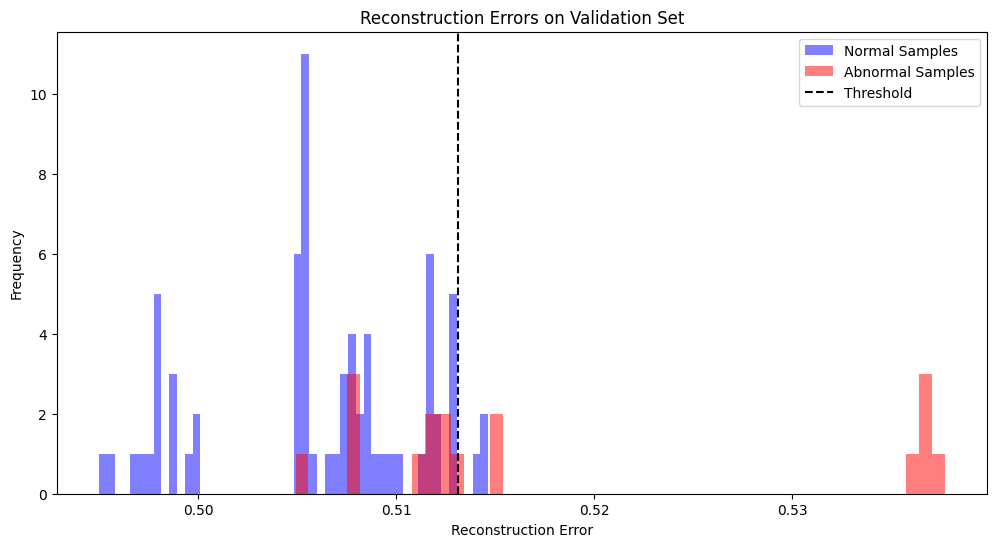

Best Threshold = 0.515117, Best F1 Score = 0.5714
Evaluation on Test Set:
Accuracy = 0.8636363636363636
Precision = 1.0
Recall = 0.4
F1 Score = 0.5714285714285715
Confusion Matrix:
 [[68  0]
 [12  8]]
Fold 2
Epoch 1/15, Loss: 1.135579
Epoch 2/15, Loss: 0.776192
Epoch 3/15, Loss: 0.559218
Epoch 4/15, Loss: 0.532207
Epoch 5/15, Loss: 0.528339
Epoch 6/15, Loss: 0.527121
Epoch 7/15, Loss: 0.526414
Epoch 8/15, Loss: 0.525801
Epoch 9/15, Loss: 0.525292
Epoch 10/15, Loss: 0.524949
Epoch 11/15, Loss: 0.524592
Epoch 12/15, Loss: 0.524360
Epoch 13/15, Loss: 0.524224
Epoch 14/15, Loss: 0.523947
Epoch 15/15, Loss: 0.523689
Best threshold: 0.5116689412882833, Best F1 Score: 0.606060606060606


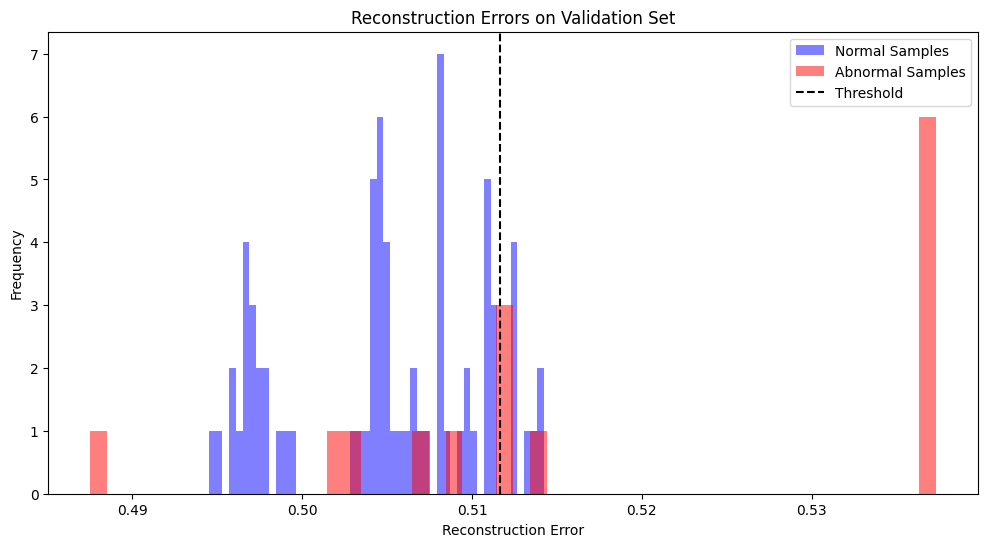

Best Threshold = 0.511623, Best F1 Score = 0.7600
Evaluation on Test Set:
Accuracy = 0.8636363636363636
Precision = 0.6785714285714286
Recall = 0.8636363636363636
F1 Score = 0.76
Confusion Matrix:
 [[57  9]
 [ 3 19]]
Fold 3
Epoch 1/15, Loss: 1.140612
Epoch 2/15, Loss: 0.808123
Epoch 3/15, Loss: 0.564418
Epoch 4/15, Loss: 0.531404
Epoch 5/15, Loss: 0.527647
Epoch 6/15, Loss: 0.526736
Epoch 7/15, Loss: 0.526110
Epoch 8/15, Loss: 0.525509
Epoch 9/15, Loss: 0.525142
Epoch 10/15, Loss: 0.524754
Epoch 11/15, Loss: 0.524433
Epoch 12/15, Loss: 0.524197
Epoch 13/15, Loss: 0.524069
Epoch 14/15, Loss: 0.523852
Epoch 15/15, Loss: 0.523768
Best threshold: 0.513122229263036, Best F1 Score: 0.6206896551724139


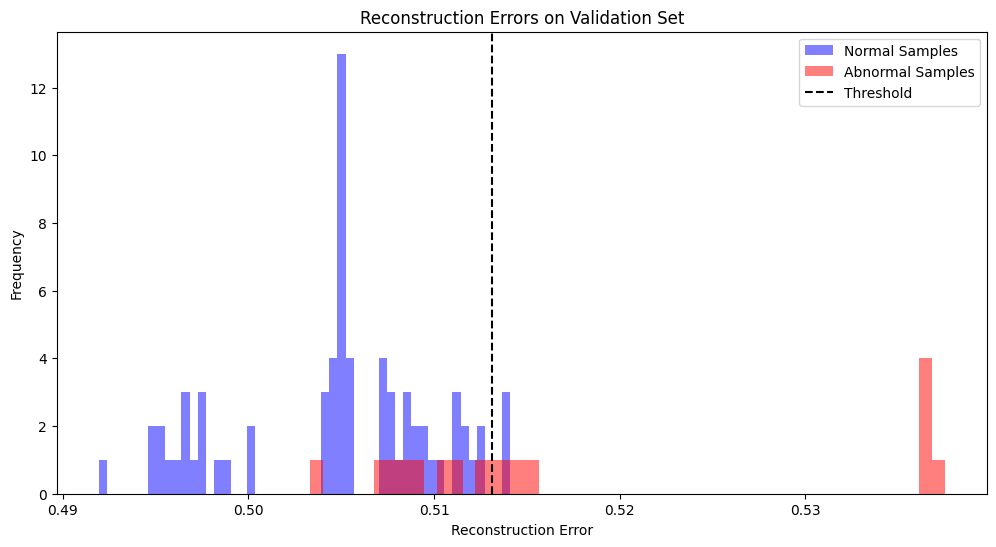

Best Threshold = 0.513104, Best F1 Score = 0.5161
Evaluation on Test Set:
Accuracy = 0.8275862068965517
Precision = 0.6666666666666666
Recall = 0.42105263157894735
F1 Score = 0.5161290322580646
Confusion Matrix:
 [[64  4]
 [11  8]]
Fold 4
Epoch 1/15, Loss: 1.140989
Epoch 2/15, Loss: 0.800832
Epoch 3/15, Loss: 0.563747
Epoch 4/15, Loss: 0.532256
Epoch 5/15, Loss: 0.528283
Epoch 6/15, Loss: 0.527135
Epoch 7/15, Loss: 0.526322
Epoch 8/15, Loss: 0.525715
Epoch 9/15, Loss: 0.525215
Epoch 10/15, Loss: 0.524900
Epoch 11/15, Loss: 0.524607
Epoch 12/15, Loss: 0.524382
Epoch 13/15, Loss: 0.524194
Epoch 14/15, Loss: 0.523908
Epoch 15/15, Loss: 0.523775
Best threshold: 0.5079693782209146, Best F1 Score: 0.6530612244897959


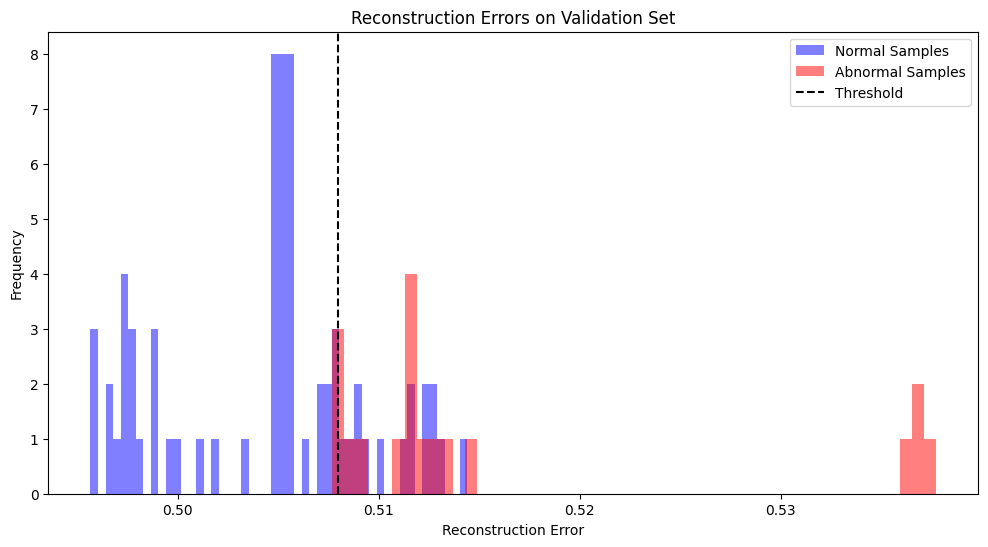

Best Threshold = 0.510071, Best F1 Score = 0.6667
Evaluation on Test Set:
Accuracy = 0.8275862068965517
Precision = 0.5555555555555556
Recall = 0.8333333333333334
F1 Score = 0.6666666666666667
Confusion Matrix:
 [[57 12]
 [ 3 15]]
Fold 5
Epoch 1/15, Loss: 1.144305
Epoch 2/15, Loss: 0.815744
Epoch 3/15, Loss: 0.564800
Epoch 4/15, Loss: 0.530974
Epoch 5/15, Loss: 0.527313
Epoch 6/15, Loss: 0.526549
Epoch 7/15, Loss: 0.526050
Epoch 8/15, Loss: 0.525492
Epoch 9/15, Loss: 0.525060
Epoch 10/15, Loss: 0.524760
Epoch 11/15, Loss: 0.524497
Epoch 12/15, Loss: 0.524203
Epoch 13/15, Loss: 0.523963
Epoch 14/15, Loss: 0.523787
Epoch 15/15, Loss: 0.523758
Best threshold: 0.5144980880949233, Best F1 Score: 0.6666666666666666


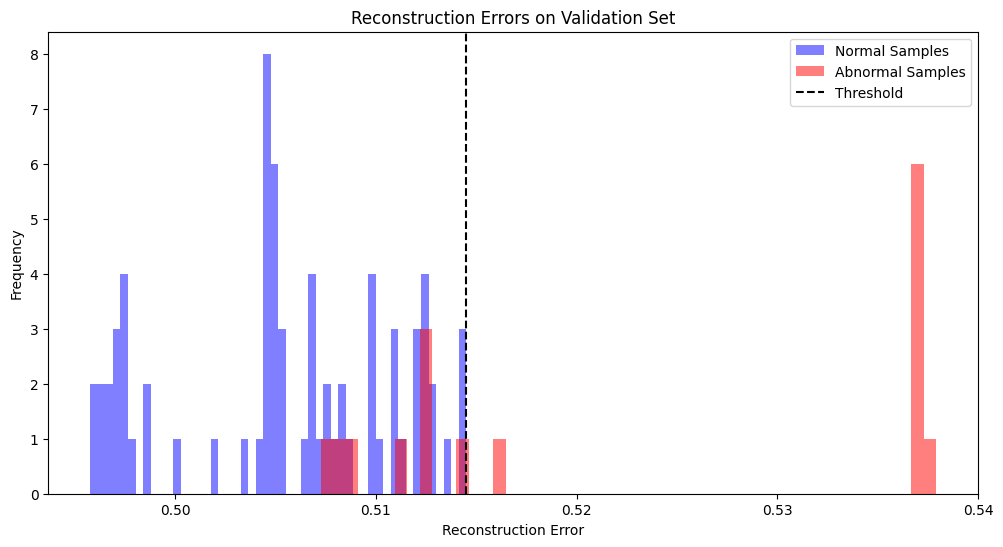

Best Threshold = 0.514602, Best F1 Score = 0.7097
Evaluation on Test Set:
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.55
F1 Score = 0.7096774193548387
Confusion Matrix:
 [[67  0]
 [ 9 11]]


In [8]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension    
    val_errors_test = compute_reconstruction_loss(model, X_test)
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))



In [9]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.823798328108673, 0.6665661136249371, 0.6256246677299309, 0.6109771061383965)

# Observation:







Average sscores:

Accuracy = 0.823798328108673

Precision = 0.6665661136249371

Recall = 0.6256246677299309

F1 Score = 0.6256246677299309


Best:

Accuracy = 0.8636363636363636

Precision = 0.6785714285714286

Recall = 0.8636363636363636

F1 Score = 0.76

Confusion Matrix:

 [[57  9]

 [ 3 19]]
